# 熱成像超解析度 - 三種方法比較
## Method 1: RGB 灰階作 GT | Method 2: 自監督 | Method 3: 混合式

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

np.random.seed(42)
torch.manual_seed(42)

Device: cuda


In [2]:
import os

DATA_DIR = Path(os.getcwd()) / 'output' / 'synchronized'
THERMAL_DIR = DATA_DIR / 'thermal'
RGB_DIR = DATA_DIR / 'rgb'
METADATA_FILE = DATA_DIR / 'metadata.csv'

OUTPUT_DIR = Path(os.getcwd()) / 'output' / 'super_resolution'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f'當前工作目錄: {os.getcwd()}')
print(f'資料目錄: {DATA_DIR}')
print(f'Metadata 檔案: {METADATA_FILE}')
print(f'檔案存在: {METADATA_FILE.exists()}')

if not METADATA_FILE.exists():
    print('\n搜尋 metadata.csv...')
    for root, dirs, files in os.walk(os.getcwd()):
        for f in files:
            if 'metadata' in f.lower():
                print(f'找到: {os.path.join(root, f)}')
else:
    metadata_df = pd.read_csv(METADATA_FILE)
    print(f'\n成功載入 {len(metadata_df)} 筆配對資料')
    print(metadata_df.head())

當前工作目錄: /home/gary/ipynb
資料目錄: /home/gary/ipynb/output/synchronized
Metadata 檔案: /home/gary/ipynb/output/synchronized/metadata.csv
檔案存在: True

成功載入 661 筆配對資料
      pair_id                timestamp  rgb_frame_idx thermal_file  \
0  pair_00000  2020-09-24 13:09:30.268              0   log000.txt   
1  pair_00001  2020-09-24 13:09:31.268             24   log000.txt   
2  pair_00002  2020-09-24 13:09:32.268             49   log000.txt   
3  pair_00003  2020-09-24 13:09:33.268             74   log000.txt   
4  pair_00004  2020-09-24 13:09:34.268             98   log000.txt   

   thermal_error_ms  rgb_error_ms  
0               0.0      0.000000  
1               0.0     27.158492  
2               0.0     13.781921  
3               0.0      0.405351  
4               0.0     27.563843  


In [5]:
INPUT_RES = (256, 256)
OUTPUT_RES = (256, 256)
BATCH_SIZE = 8
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
LOSS_WEIGHTS = {'L1': 0.3, 'perceptual': 0.4, 'tv': 0.3}

print(f'輸入解析度: {INPUT_RES}')
print(f'輸出解析度: {OUTPUT_RES}')
print(f'批次大小: {BATCH_SIZE}')
print(f'訓練回合: {NUM_EPOCHS}')

輸入解析度: (256, 256)
輸出解析度: (256, 256)
批次大小: 8
訓練回合: 100


In [6]:
class ThermalRGBDataset(Dataset):
    def __init__(self, metadata_df, thermal_dir, rgb_dir, method='method1'):
        self.metadata_df = metadata_df
        self.thermal_dir = thermal_dir
        self.rgb_dir = rgb_dir
        self.method = method
    
    def __len__(self):
        return len(self.metadata_df)
    
    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        pair_id = row['pair_id']
        
        thermal_path = self.thermal_dir / f"{pair_id}_thermal.npy"
        thermal = np.load(thermal_path).astype(np.float32) / 255.0
        
        rgb_path = self.rgb_dir / f"{pair_id}_rgb.npy"
        rgb = np.load(rgb_path).astype(np.float32) / 255.0
        
        if thermal.shape != INPUT_RES:
            thermal = cv2.resize(thermal, INPUT_RES[::-1], interpolation=cv2.INTER_CUBIC)
        
        if rgb.shape[:2] != OUTPUT_RES:
            rgb_resized = cv2.resize(rgb, OUTPUT_RES[::-1], interpolation=cv2.INTER_CUBIC)
        else:
            rgb_resized = rgb
        
        if len(rgb_resized.shape) == 3:
            rgb_gray = cv2.cvtColor((rgb_resized * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0
        else:
            rgb_gray = rgb_resized
        
        thermal_tensor = torch.from_numpy(thermal).unsqueeze(0)
        rgb_tensor = torch.from_numpy(rgb_gray).unsqueeze(0)
        
        if self.method == 'method2':
            noise = torch.randn_like(thermal_tensor) * 0.1
            thermal_noisy = torch.clamp(thermal_tensor + noise, 0, 1)
            return {'input': thermal_noisy, 'target': thermal_tensor}
        else:
            return {'input': thermal_tensor, 'target': rgb_tensor}

def create_dataloaders(metadata_df, thermal_dir, rgb_dir, method, batch_size=BATCH_SIZE):
    total_size = len(metadata_df)
    val_size = int(total_size * VAL_SPLIT)
    test_size = int(total_size * TEST_SPLIT)
    train_size = total_size - val_size - test_size
    
    train_df = metadata_df.iloc[:train_size]
    val_df = metadata_df.iloc[train_size:train_size + val_size]
    test_df = metadata_df.iloc[train_size + val_size:]
    
    train_dataset = ThermalRGBDataset(train_df, thermal_dir, rgb_dir, method=method)
    val_dataset = ThermalRGBDataset(val_df, thermal_dir, rgb_dir, method=method)
    test_dataset = ThermalRGBDataset(test_df, thermal_dir, rgb_dir, method=method)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    print(f'資料分割: 訓練 {train_size} / 驗證 {val_size} / 測試 {test_size}')
    return train_loader, val_loader, test_loader

print('資料集類別已定義')

資料集類別已定義


In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = self._conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = self._conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.enc3 = self._conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.enc4 = self._conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.bottleneck = self._conv_block(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.dec4 = self._conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec3 = self._conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = self._conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = self._conv_block(128, 64)
        self.final = nn.Conv2d(64, out_channels, 1, 1)
    
    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))
        dec4 = self.dec4(torch.cat([self.upconv4(bottleneck), enc4], 1))
        dec3 = self.dec3(torch.cat([self.upconv3(dec4), enc3], 1))
        dec2 = self.dec2(torch.cat([self.upconv2(dec3), enc2], 1))
        dec1 = self.dec1(torch.cat([self.upconv1(dec2), enc1], 1))
        return torch.sigmoid(self.final(dec1))

print('U-Net 模型已定義')

U-Net 模型已定義


In [8]:
class PerceptualLoss(nn.Module):
    def forward(self, pred, target):
        pred_grad_x = torch.abs(pred[:, :, :, :-1] - pred[:, :, :, 1:])
        pred_grad_y = torch.abs(pred[:, :, :-1, :] - pred[:, :, 1:, :])
        target_grad_x = torch.abs(target[:, :, :, :-1] - target[:, :, :, 1:])
        target_grad_y = torch.abs(target[:, :, :-1, :] - target[:, :, 1:, :])
        return torch.mean(torch.abs(pred_grad_x - target_grad_x)) + torch.mean(torch.abs(pred_grad_y - target_grad_y))

class TVLoss(nn.Module):
    def forward(self, x):
        diff_x = torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])
        diff_y = torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :])
        return torch.mean(diff_x) + torch.mean(diff_y)

print('損失函數已定義')

損失函數已定義


In [9]:
def train_model(model, train_loader, val_loader, method, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    l1_loss = nn.L1Loss()
    perc_loss = PerceptualLoss()
    tv_loss = TVLoss()
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            input_img = batch['input'].to(device)
            target_img = batch['target'].to(device)
            optimizer.zero_grad()
            output = model(input_img)
            
            if method in ['method1', 'method2']:
                loss = l1_loss(output, target_img)
            else:
                l1 = l1_loss(output, target_img)
                perc = perc_loss(output, target_img)
                tv = tv_loss(output)
                loss = LOSS_WEIGHTS['L1'] * l1 + LOSS_WEIGHTS['perceptual'] * perc + LOSS_WEIGHTS['tv'] * tv
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                input_img = batch['input'].to(device)
                target_img = batch['target'].to(device)
                output = model(input_img)
                if method in ['method1', 'method2']:
                    loss = l1_loss(output, target_img)
                else:
                    l1 = l1_loss(output, target_img)
                    perc = perc_loss(output, target_img)
                    tv = tv_loss(output)
                    loss = LOSS_WEIGHTS['L1'] * l1 + LOSS_WEIGHTS['perceptual'] * perc + LOSS_WEIGHTS['tv'] * tv
                val_loss += loss.item()
        
        val_losses.append(val_loss / len(val_loader))
        scheduler.step()
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}: Train {train_losses[-1]:.4f} | Val {val_losses[-1]:.4f}')
    
    return model, train_losses, val_losses

print('訓練函數已定義')

訓練函數已定義


In [10]:
def evaluate_model(model, test_loader):
    model.eval()
    psnr_scores, ssim_scores, predictions, targets, inputs = [], [], [], [], []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='評估中'):
            input_img = batch['input'].to(device)
            target_img = batch['target'].to(device)
            output = model(input_img)
            
            for i in range(output.shape[0]):
                pred_np = output[i, 0].cpu().numpy()
                target_np = target_img[i, 0].cpu().numpy()
                input_np = input_img[i, 0].cpu().numpy()
                
                psnr_scores.append(psnr(target_np, pred_np, data_range=1.0))
                ssim_scores.append(ssim(target_np, pred_np, data_range=1.0))
                predictions.append(pred_np)
                targets.append(target_np)
                inputs.append(input_np)
    
    return {
        'psnr_mean': np.mean(psnr_scores), 'psnr_std': np.std(psnr_scores),
        'ssim_mean': np.mean(ssim_scores), 'ssim_std': np.std(ssim_scores),
        'psnr_scores': psnr_scores, 'ssim_scores': ssim_scores,
        'predictions': predictions, 'targets': targets, 'inputs': inputs
    }

print('評估函數已定義')

評估函數已定義


## 方法 1: RGB 灰階作為 GT

In [11]:
print('\n' + '='*70)
print('方法 1: RGB 灰階作為 Ground Truth')
print('='*70)

train_loader_m1, val_loader_m1, test_loader_m1 = create_dataloaders(metadata_df, THERMAL_DIR, RGB_DIR, 'method1')
model_m1 = UNet(1, 1).to(device)
print(f'模型參數數量: {sum(p.numel() for p in model_m1.parameters())}')

model_m1, train_losses_m1, val_losses_m1 = train_model(model_m1, train_loader_m1, val_loader_m1, 'method1')
results_m1 = evaluate_model(model_m1, test_loader_m1)

print(f'\n方法 1 結果:')
print(f'  PSNR: {results_m1["psnr_mean"]:.2f} ± {results_m1["psnr_std"]:.2f} dB')
print(f'  SSIM: {results_m1["ssim_mean"]:.4f} ± {results_m1["ssim_std"]:.4f}')

torch.save(model_m1.state_dict(), OUTPUT_DIR / 'method1_model.pth')
print('模型已儲存')


方法 1: RGB 灰階作為 Ground Truth
資料分割: 訓練 463 / 驗證 99 / 測試 99
模型參數數量: 31030593


Epoch 5: Train 0.1752 | Val 0.1880


Epoch 10: Train 0.1637 | Val 0.1718


Epoch 15: Train 0.1584 | Val 0.1697


Epoch 20: Train 0.1537 | Val 0.1756


Epoch 25: Train 0.1498 | Val 0.1699


Epoch 30: Train 0.1502 | Val 0.1780


Epoch 35: Train 0.1468 | Val 0.1721


Epoch 40: Train 0.1462 | Val 0.1627


Epoch 45: Train 0.1454 | Val 0.1697


Epoch 50: Train 0.1449 | Val 0.1661


Epoch 55: Train 0.1444 | Val 0.1636


Epoch 60: Train 0.1441 | Val 0.1622


Epoch 65: Train 0.1439 | Val 0.1651


Epoch 70: Train 0.1437 | Val 0.1646


Epoch 75: Train 0.1437 | Val 0.1635


Epoch 80: Train 0.1436 | Val 0.1654


Epoch 85: Train 0.1435 | Val 0.1645


Epoch 90: Train 0.1435 | Val 0.1640


Epoch 95: Train 0.1434 | Val 0.1643


Epoch 100: Train 0.1434 | Val 0.1641


評估中: 100%|██████████| 13/13 [00:01<00:00,  9.16it/s]



方法 1 結果:
  PSNR: 13.24 ± 0.39 dB
  SSIM: 0.3337 ± 0.0116
模型已儲存


## 方法 2: 自監督去雜訊

In [12]:
print('\n' + '='*70)
print('方法 2: 自監督去雜訊')
print('='*70)

train_loader_m2, val_loader_m2, test_loader_m2 = create_dataloaders(metadata_df, THERMAL_DIR, RGB_DIR, 'method2')
model_m2 = UNet(1, 1).to(device)

model_m2, train_losses_m2, val_losses_m2 = train_model(model_m2, train_loader_m2, val_loader_m2, 'method2')
results_m2 = evaluate_model(model_m2, test_loader_m2)

print(f'\n方法 2 結果:')
print(f'  PSNR: {results_m2["psnr_mean"]:.2f} ± {results_m2["psnr_std"]:.2f} dB')
print(f'  SSIM: {results_m2["ssim_mean"]:.4f} ± {results_m2["ssim_std"]:.4f}')

torch.save(model_m2.state_dict(), OUTPUT_DIR / 'method2_model.pth')
print('模型已儲存')


方法 2: 自監督去雜訊
資料分割: 訓練 463 / 驗證 99 / 測試 99


Epoch 5: Train 0.0082 | Val 0.0076


Epoch 10: Train 0.0077 | Val 0.0088


Epoch 15: Train 0.0076 | Val 0.0074


Epoch 20: Train 0.0076 | Val 0.0074


Epoch 25: Train 0.0075 | Val 0.0074


Epoch 30: Train 0.0075 | Val 0.0074


Epoch 35: Train 0.0075 | Val 0.0074


Epoch 40: Train 0.0075 | Val 0.0074


Epoch 45: Train 0.0074 | Val 0.0074


Epoch 50: Train 0.0074 | Val 0.0074


Epoch 55: Train 0.0074 | Val 0.0074


Epoch 60: Train 0.0074 | Val 0.0073


Epoch 65: Train 0.0074 | Val 0.0073


Epoch 70: Train 0.0074 | Val 0.0073


Epoch 75: Train 0.0074 | Val 0.0073


Epoch 80: Train 0.0074 | Val 0.0073


Epoch 85: Train 0.0074 | Val 0.0074


Epoch 90: Train 0.0074 | Val 0.0073


Epoch 95: Train 0.0074 | Val 0.0073


Epoch 100: Train 0.0074 | Val 0.0073


評估中: 100%|██████████| 13/13 [00:01<00:00,  8.85it/s]



方法 2 結果:
  PSNR: 40.56 ± 0.32 dB
  SSIM: 0.9761 ± 0.0028
模型已儲存


## 方法 3: 混合式 (RGB + Perceptual + TV)

In [13]:
print('\n' + '='*70)
print('方法 3: 混合式損失函數')
print('='*70)

train_loader_m3, val_loader_m3, test_loader_m3 = create_dataloaders(metadata_df, THERMAL_DIR, RGB_DIR, 'method3')
model_m3 = UNet(1, 1).to(device)

model_m3, train_losses_m3, val_losses_m3 = train_model(model_m3, train_loader_m3, val_loader_m3, 'method3')
results_m3 = evaluate_model(model_m3, test_loader_m3)

print(f'\n方法 3 結果:')
print(f'  PSNR: {results_m3["psnr_mean"]:.2f} ± {results_m3["psnr_std"]:.2f} dB')
print(f'  SSIM: {results_m3["ssim_mean"]:.4f} ± {results_m3["ssim_std"]:.4f}')

torch.save(model_m3.state_dict(), OUTPUT_DIR / 'method3_model.pth')
print('模型已儲存')


方法 3: 混合式損失函數
資料分割: 訓練 463 / 驗證 99 / 測試 99


Epoch 5: Train 0.0701 | Val 0.0731


Epoch 10: Train 0.0697 | Val 0.0726


Epoch 15: Train 0.0694 | Val 0.0719


Epoch 20: Train 0.0694 | Val 0.0727


Epoch 25: Train 0.0693 | Val 0.0717


Epoch 30: Train 0.0692 | Val 0.0715


Epoch 35: Train 0.0691 | Val 0.0717


Epoch 40: Train 0.0691 | Val 0.0723


Epoch 45: Train 0.0690 | Val 0.0720


Epoch 50: Train 0.0690 | Val 0.0727


Epoch 55: Train 0.0690 | Val 0.0721


Epoch 60: Train 0.0690 | Val 0.0716


Epoch 65: Train 0.0690 | Val 0.0718


Epoch 70: Train 0.0690 | Val 0.0720


Epoch 75: Train 0.0689 | Val 0.0720


Epoch 80: Train 0.0689 | Val 0.0720


Epoch 85: Train 0.0689 | Val 0.0719


Epoch 90: Train 0.0689 | Val 0.0720


Epoch 95: Train 0.0689 | Val 0.0719


Epoch 100: Train 0.0689 | Val 0.0719


評估中: 100%|██████████| 13/13 [00:01<00:00,  9.11it/s]



方法 3 結果:
  PSNR: 12.82 ± 0.20 dB
  SSIM: 0.4357 ± 0.0105
模型已儲存


## 結果比較

In [14]:
comparison_df = pd.DataFrame({
    '方法': ['方法 1 (RGB GT)', '方法 2 (自監督)', '方法 3 (混合)'],
    'PSNR 平均': [results_m1['psnr_mean'], results_m2['psnr_mean'], results_m3['psnr_mean']],
    'PSNR 標準差': [results_m1['psnr_std'], results_m2['psnr_std'], results_m3['psnr_std']],
    'SSIM 平均': [results_m1['ssim_mean'], results_m2['ssim_mean'], results_m3['ssim_mean']],
    'SSIM 標準差': [results_m1['ssim_std'], results_m2['ssim_std'], results_m3['ssim_std']]
})

print('\n' + '='*70)
print('三種方法比較')
print('='*70)
print(comparison_df.to_string(index=False))

comparison_df.to_csv(OUTPUT_DIR / 'comparison.csv', index=False)
print(f'\n比較表已儲存至 {OUTPUT_DIR / "comparison.csv"}')


三種方法比較
           方法   PSNR 平均  PSNR 標準差  SSIM 平均  SSIM 標準差
方法 1 (RGB GT) 13.237560  0.387330 0.333720  0.011586
   方法 2 (自監督) 40.563616  0.316421 0.976099  0.002847
    方法 3 (混合) 12.822321  0.196113 0.435713  0.010513

比較表已儲存至 /home/gary/ipynb/output/super_resolution/comparison.csv


## 訓練曲線視覺化

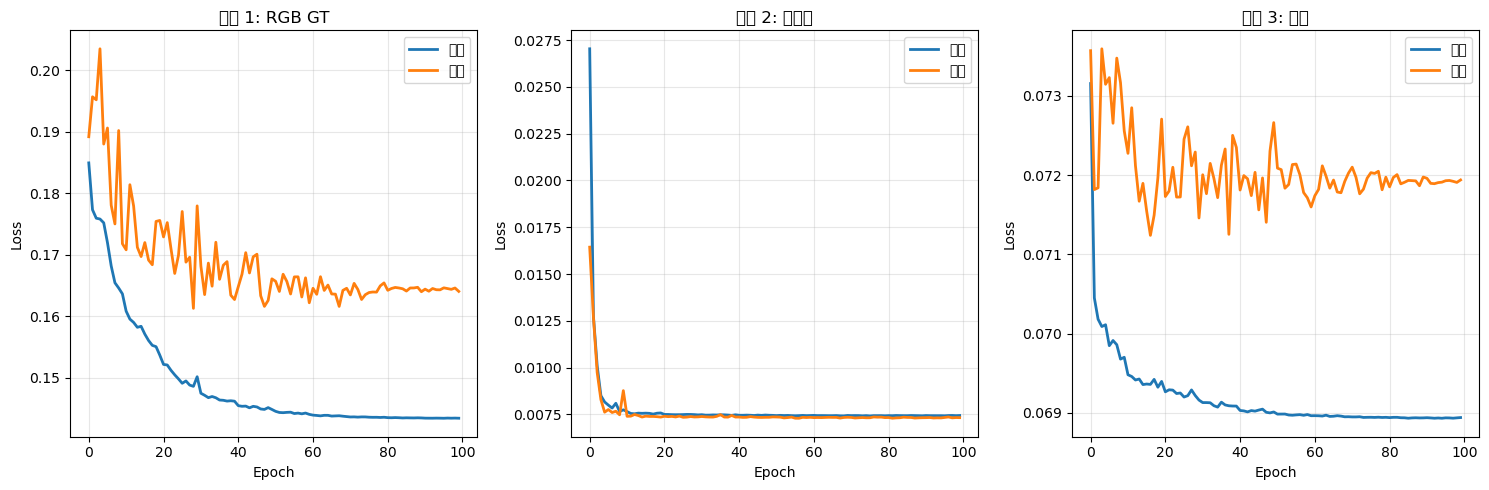

訓練曲線已儲存至 /home/gary/ipynb/output/super_resolution/training_curves.png


In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (losses_train, losses_val, title) in enumerate([
    (train_losses_m1, val_losses_m1, '方法 1: RGB GT'),
    (train_losses_m2, val_losses_m2, '方法 2: 自監督'),
    (train_losses_m3, val_losses_m3, '方法 3: 混合')
]):
    axes[idx].plot(losses_train, label='訓練', linewidth=2)
    axes[idx].plot(losses_val, label='驗證', linewidth=2)
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Loss')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_curves.png', dpi=100, bbox_inches='tight')
plt.show()
print(f'訓練曲線已儲存至 {OUTPUT_DIR / "training_curves.png"}')

## 視覺化比較

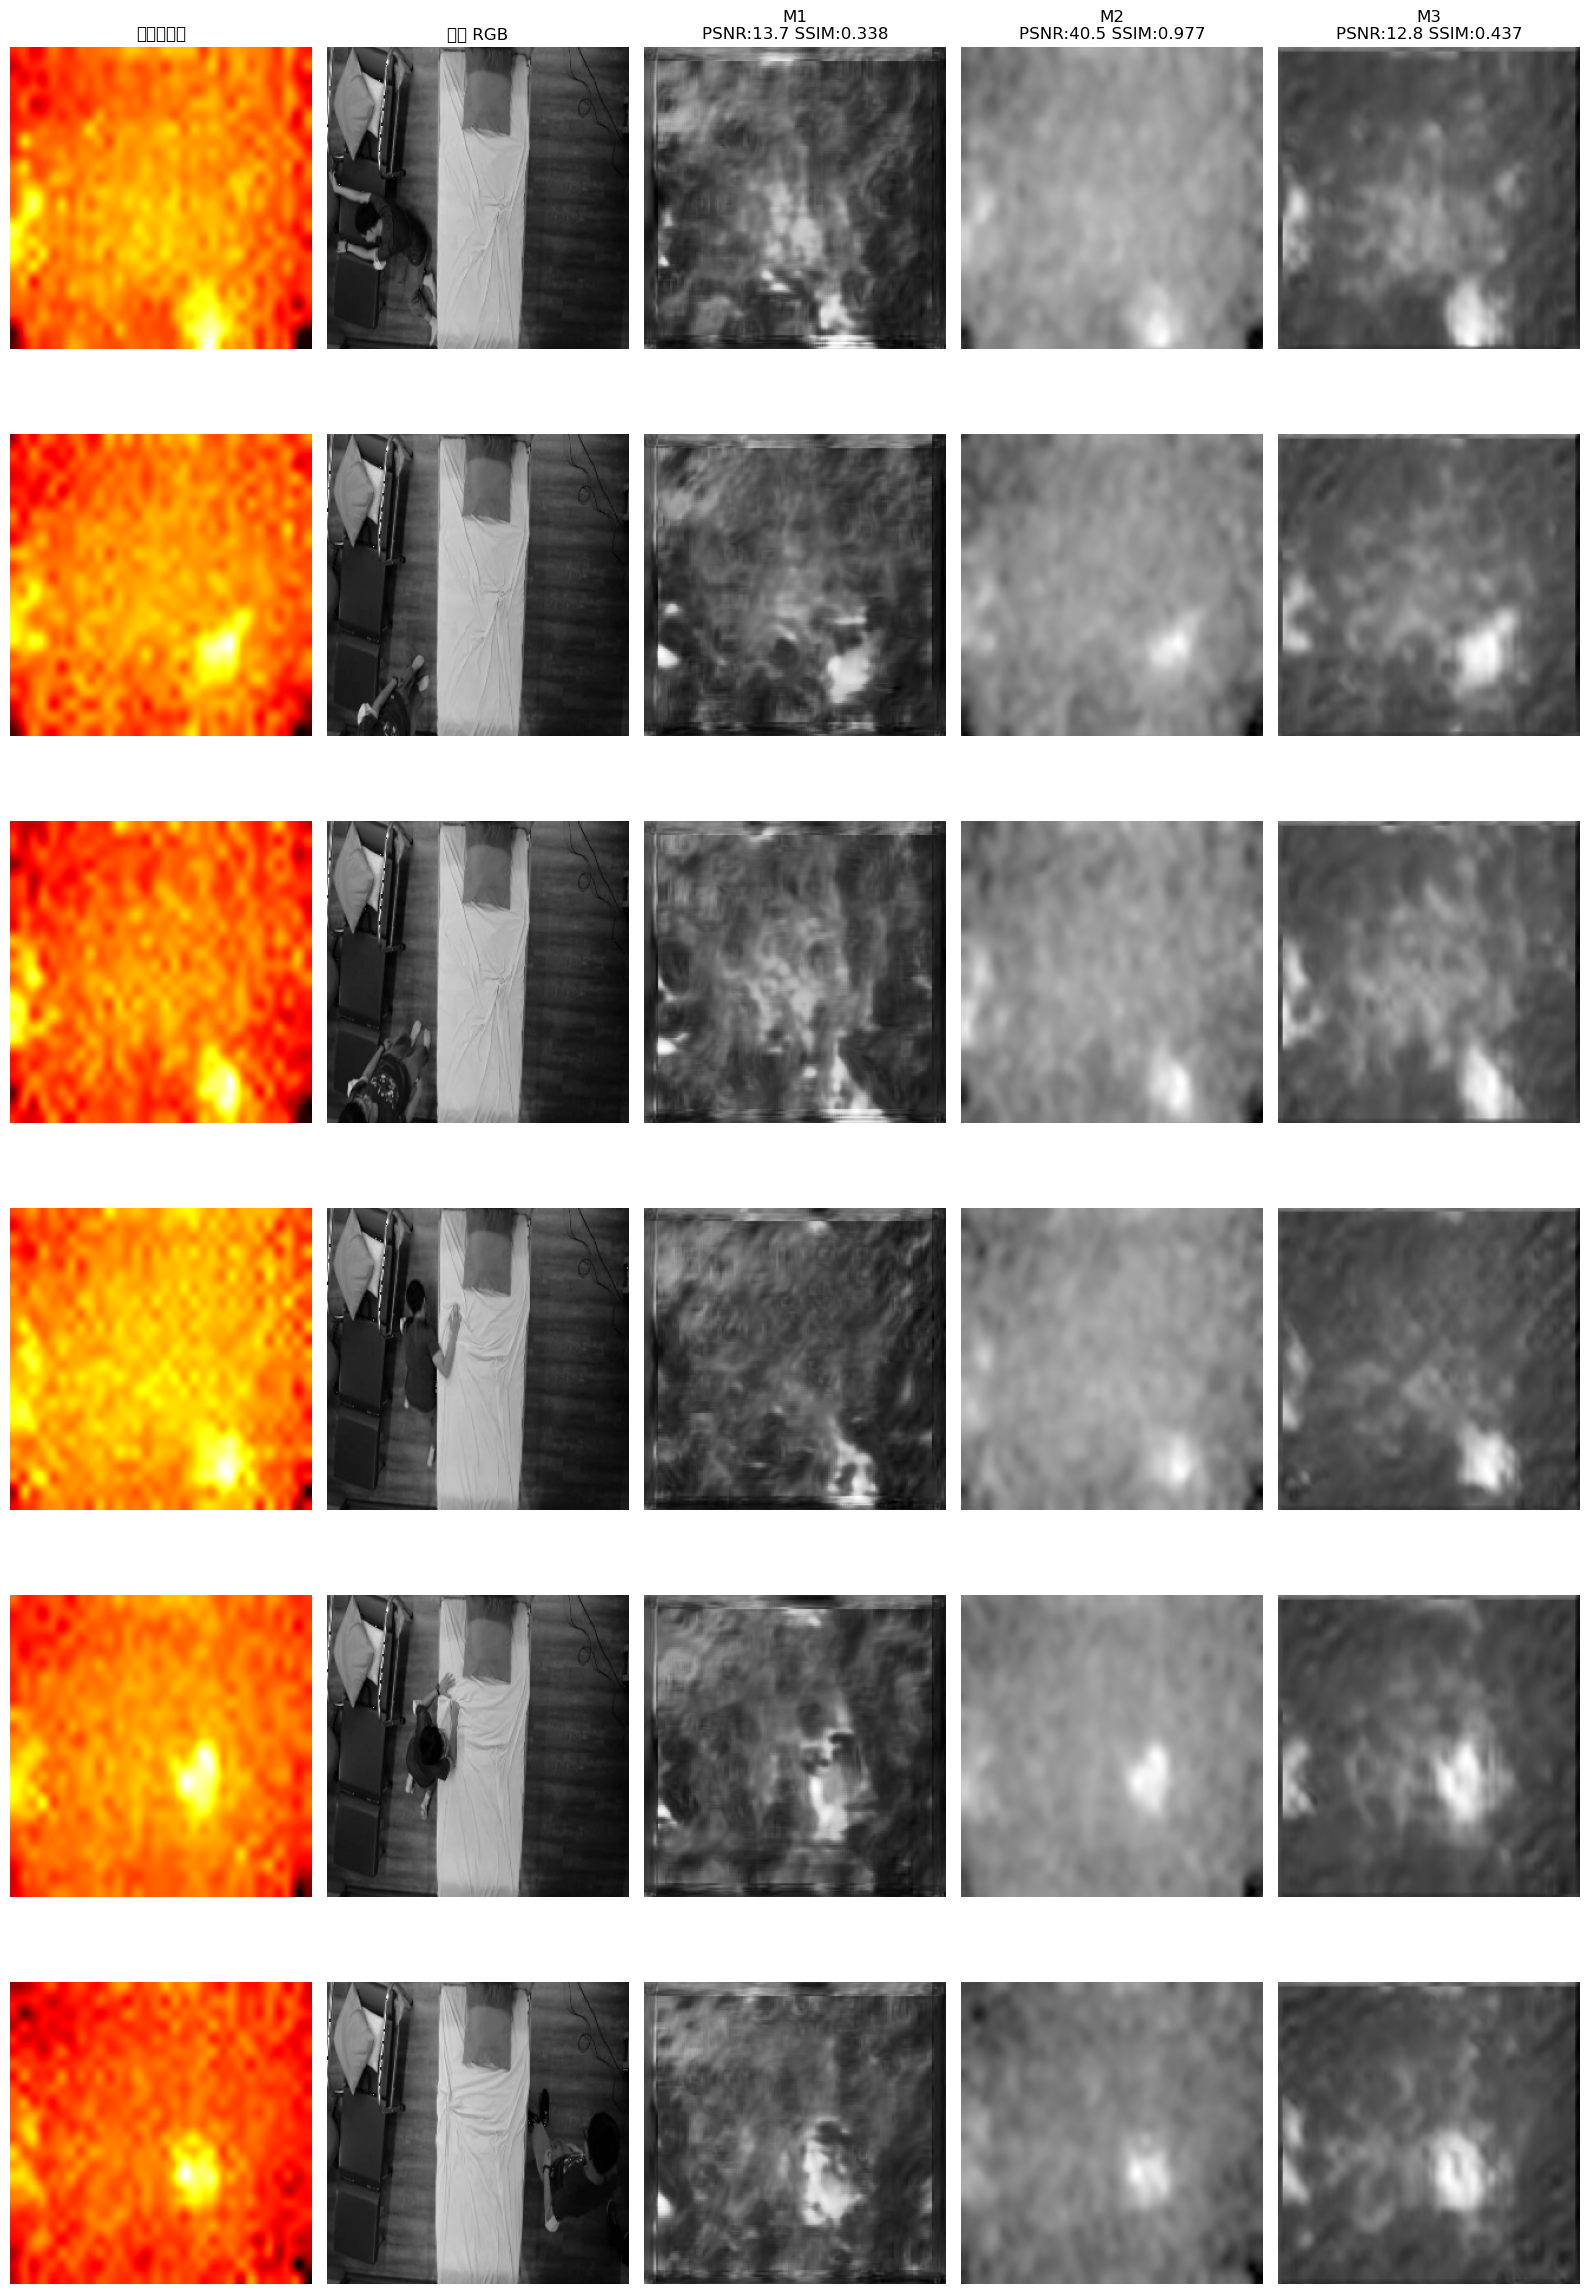

視覺化比較已儲存至 /home/gary/ipynb/output/super_resolution/visual_comparison.png


In [16]:
num_samples = 6
indices = np.linspace(0, len(results_m1['inputs']) - 1, num_samples, dtype=int)

fig, axes = plt.subplots(num_samples, 5, figsize=(16, 4*num_samples))

for row_idx, sample_idx in enumerate(indices):
    axes[row_idx, 0].imshow(results_m1['inputs'][sample_idx], cmap='hot')
    axes[row_idx, 0].set_title('輸入熱成像' if row_idx == 0 else '')
    axes[row_idx, 0].axis('off')
    
    axes[row_idx, 1].imshow(results_m1['targets'][sample_idx], cmap='gray')
    axes[row_idx, 1].set_title('目標 RGB' if row_idx == 0 else '')
    axes[row_idx, 1].axis('off')
    
    for col_idx, (name, res) in enumerate([('M1', results_m1), ('M2', results_m2), ('M3', results_m3)]):
        pred = res['predictions'][sample_idx]
        psnr_val = res['psnr_scores'][sample_idx]
        ssim_val = res['ssim_scores'][sample_idx]
        
        axes[row_idx, col_idx + 2].imshow(pred, cmap='gray')
        if row_idx == 0:
            axes[row_idx, col_idx + 2].set_title(f'{name}\nPSNR:{psnr_val:.1f} SSIM:{ssim_val:.3f}')
        axes[row_idx, col_idx + 2].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'visual_comparison.png', dpi=100, bbox_inches='tight')
plt.show()
print(f'視覺化比較已儲存至 {OUTPUT_DIR / "visual_comparison.png"}')

## 指標分佈圖

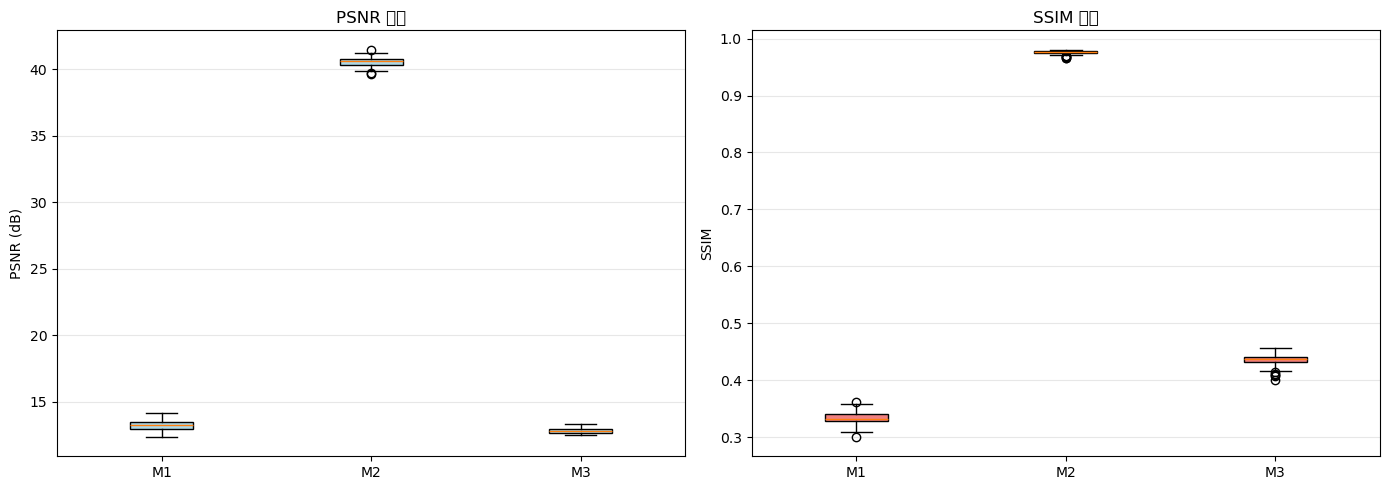

指標分佈圖已儲存至 /home/gary/ipynb/output/super_resolution/metrics_distribution.png


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

psnr_data = [results_m1['psnr_scores'], results_m2['psnr_scores'], results_m3['psnr_scores']]
bp1 = axes[0].boxplot(psnr_data, labels=['M1', 'M2', 'M3'], patch_artist=True)
for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')
axes[0].set_ylabel('PSNR (dB)')
axes[0].set_title('PSNR 分佈')
axes[0].grid(True, alpha=0.3, axis='y')

ssim_data = [results_m1['ssim_scores'], results_m2['ssim_scores'], results_m3['ssim_scores']]
bp2 = axes[1].boxplot(ssim_data, labels=['M1', 'M2', 'M3'], patch_artist=True)
for patch in bp2['boxes']:
    patch.set_facecolor('lightcoral')
axes[1].set_ylabel('SSIM')
axes[1].set_title('SSIM 分佈')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'metrics_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
print(f'指標分佈圖已儲存至 {OUTPUT_DIR / "metrics_distribution.png"}')

## 完成！

In [18]:
print('\n' + '='*70)
print('訓練完成！')
print('='*70)
print(f'\n輸出目錄: {OUTPUT_DIR}')
print('\n已儲存檔案:')
print('  - method1_model.pth (方法 1 模型)')
print('  - method2_model.pth (方法 2 模型)')
print('  - method3_model.pth (方法 3 模型)')
print('  - comparison.csv (比較表)')
print('  - training_curves.png (訓練曲線)')
print('  - visual_comparison.png (視覺化比較)')
print('  - metrics_distribution.png (指標分佈)')
print('\n' + '='*70)


訓練完成！

輸出目錄: /home/gary/ipynb/output/super_resolution

已儲存檔案:
  - method1_model.pth (方法 1 模型)
  - method2_model.pth (方法 2 模型)
  - method3_model.pth (方法 3 模型)
  - comparison.csv (比較表)
  - training_curves.png (訓練曲線)
  - visual_comparison.png (視覺化比較)
  - metrics_distribution.png (指標分佈)

